# Making neural network interpretable with attribution
## Toy problems
_Darius AFCHAR_

We provide an implementation notebook of the toy problems introduced in the paper.

#### Tested with
- tensorflow: 2.2.0
- numpy: 1.18.0

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.set_cmap('coolwarm')
g_cmap = sns.diverging_palette(240, 10, n=7, as_cmap=True)

%matplotlib inline

In [3]:
'''
Define several toy datasets
'''

def datagen_A(bs = 256, dist = 1.0, noise_level = 0.25):
    ''' 4 clusters separables '''
    X = np.random.normal(0, noise_level, (bs, 2))
    Y = np.ones((bs, 1))
    s = bs // 4
    X[:s] = X[:s] + [-dist, 0]
    Y[:s] = -1.
    X[s:(2*s)] = X[s:(2*s)] + [dist, 0]
    X[(2*s):(3*s)] = X[(2*s):(3*s)] + [0, dist]
    X[(3*s):] = X[(3*s):] + [0, -dist]
    Y[(3*s):] = -1.
    return X, Y

def datagen_B(bs = 256, dist = 1.0, noise_level = 0.25):
    ''' 4 clusters XOR '''
    X = np.random.normal(0, noise_level, (bs, 2))
    Y = np.ones((bs, 1))
    s = bs // 4
    X[:s] = X[:s] + [-dist, -dist]
    Y[:s] = -1.
    X[s:(2*s)] = X[s:(2*s)] + [dist, -dist]
    X[(2*s):(3*s)] = X[(2*s):(3*s)] + [-dist, dist]
    X[(3*s):] = X[(3*s):] + [dist, dist]
    Y[(3*s):] = -1.
    return X, Y

def datagen_C(bs = 256, noise_level = 0.25):
    ''' Mixed problem on two input dimensions '''
    Xa, Ya = datagen_A(bs // 2, 1, noise_level)
    Xb, Yb = datagen_B(bs // 2, 2, noise_level)
    return np.concatenate([Xa, Xb], axis=0), np.concatenate([Ya, Yb], axis=0)

def datagen_D(bs = 256, dist = 1.0, noise_level = 0.25):
    ''' Mixed problem on four input dimensions '''
    X = np.zeros((bs, 4))
    Xa, Ya = datagen_A(bs // 2, dist, noise_level)
    Xb, Yb = datagen_B(bs // 2, dist, noise_level)
    X[:bs//2,:2] = Xa
    X[bs//2:,2:] = Xb
    return X, np.concatenate([Ya, Yb], axis=0)

def make_generator(func, params):
    while True:
        yield func(**params)

Text(0.5, 1.0, 'Dataset D <dim2, dim3> ')

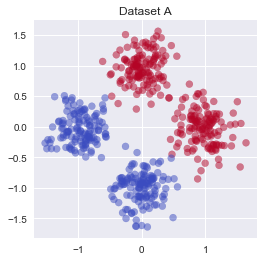

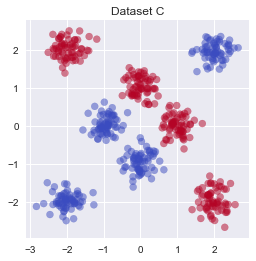

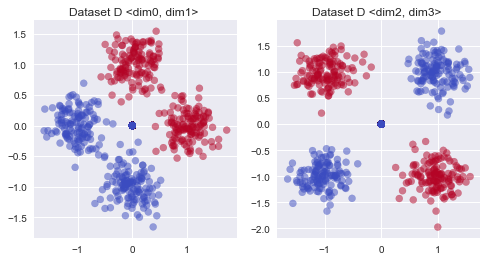

In [4]:
'''
Plot
'''
plt.figure(figsize=(4, 4))
x, y = datagen_A(512)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5)
plt.title('Dataset A')

plt.figure(figsize=(4, 4))
x, y = datagen_C(512)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5)
plt.title('Dataset C')

plt.figure(figsize=(8, 4))
x, y = datagen_D(1024)
plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5)
plt.title('Dataset D <dim0, dim1> ')
plt.subplot(1,2,2)
plt.scatter(x[:,2], x[:,3], c = y[:,0], alpha=0.5)
plt.title('Dataset D <dim2, dim3> ')


### Model

We define a model with three experts: $S1 = \{x_1\}$, $S1 = \{x_2\}$, $S3 = \{x_1, x_2\}$.

Each expert is a three-layer feed-forward neural network. The number of hidden features can be adjusted with the `hidden_dim` parameter.

In [5]:
'''
Define an interpretable feed-forward model.
Note that in this implementation, we keep the code simple and do not add the hidden layers connections,
the problem is simple enough to avoid adding them.
'''

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam

## Defines MoE agregation functions
def mask_L1(p):
    conf = tf.stop_gradient(tf.math.abs(p))
    return conf

def mask_L2(p):
    conf = tf.stop_gradient(tf.math.square(p))
    return conf

def mask_Lp(p, n = 4):
    conf2 = tf.stop_gradient(tf.math.pow(tf.math.abs(p), n))
    conf1 = tf.stop_gradient(tf.math.pow(tf.math.abs(p), n-1))
    conf = 2 * conf2 / (1 + conf1)
    return conf
    
def get_attributions(p, mask_mat, mode = 'L1'):
    if mode == 'L1':
        conf = mask_L1(p)
    elif mode == 'L2':
        conf = mask_L2(p)
    else:
        conf = mask_Lp(p)
    mask = tf.map_fn(lambda x: tf.reduce_prod(1. - x * conf, axis=-1), tf.transpose(mask_mat))
    mask = tf.transpose(mask, [1, 0])
    mask = mask * conf
    return mask

def MoE(p, mask_mat, mode = 'L1'):
    mask = get_attributions(p, mask_mat, mode)
    y = tf.reduce_sum(mask * p, axis=-1, keepdims=True) / (1e-9 + tf.reduce_sum(mask, axis=-1, keepdims=True))
    return y

## Model class
class Interpretable_FF(tf.keras.Model):
    def __init__(self, activations = 'relu', hidden_dim = 8, input_dim = 2):
        super(Interpretable_FF, self).__init__()
        F = hidden_dim
        act = activations

        ## Defines the experts connection matrices
        C_in = np.array([[1., 0., 1.],
                         [0., 1., 1.]])  # space input -> expert input 
        C_tr = np.array([[1., 0., 1.],
                         [0., 1., 1.],
                         [0., 0., 1.]])  # expert -> all experts dependencies
        C_tr_ = tf.convert_to_tensor(C_tr, 'float32')
        self.C_residual = C_tr_ - tf.eye(C_tr_.shape[0])
        
        s = Input(input_dim, name='input')

        ## Three feed-forward experts
        if input_dim == 2:
            sx = Lambda(lambda x: x[:,0:1], name='x')(s)
            sy = Lambda(lambda x: x[:,1:2], name='y')(s)
            sxy = Lambda(lambda x: x, name='xy')(s)
        else:
            sx = Lambda(lambda x: x[:,0:1], name='x0')(s)
            sy = Lambda(lambda x: x[:,1:2], name='x1')(s)
            sxy = Lambda(lambda x: x[:,2:4], name='x23')(s)

        qx = Dense(F, activation=act)(sx)
        qx = Dense(F, activation=act)(qx)
        qx = Dense(1, activation='tanh', name='qx')(qx)  # note: output in [-1, 1]

        qy = Dense(F, activation=act)(sy)
        qy = Dense(F, activation=act)(qy)
        qy = Dense(1, activation='tanh', name='qy')(qy)

        qxy = Dense(F, activation=act)(sxy)
        qxy = Dense(F, activation=act)(qxy)
        qxy = Dense(1, activation='tanh', name='qxy')(qxy)
        
        q_concat = Lambda(lambda x: tf.concat(x, axis=-1))([qx, qy, qxy])
        q_out = Lambda(lambda x: MoE(x, self.C_residual, mode='Lp'))(q_concat)
        self.model_int = Model(inputs=s, outputs=q_concat)
        self.model = Model(inputs=s, outputs=q_out)

    def compile(self):
        super(Interpretable_FF, self).compile()
        self.opt = Adam(1e-3)
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_acc = tf.keras.metrics.Mean(name='train_accuracy')
        self.model_int.compile(optimizer=self.opt)

    def call(self, x):
        return self.model(x)
    
    @staticmethod
    def custom_acc(y_true, y_pred):
        yt_ = tf.cast(y_true > 0., tf.float32)
        y_ = tf.cast(y_pred > 0., tf.float32)
        return 1 - tf.reduce_mean(tf.abs(yt_ - y_))


    def train_step(self, data):
        eps = 1e-6
        x, y = data
        p = self.model(x)
        
        with tf.GradientTape() as tape:
            p_concat = self.model_int(x, training=True)

            ## E-step
            mask = get_attributions(p_concat, self.C_residual, mode='L2')
            mask = mask / (tf.reduce_sum(mask, axis=-1, keepdims=True) + 1e-9)
            n_mask = tf.reduce_sum(mask, axis=0) + 1e-9  # -- for the mean computation

            ## M-step
            red_p = (1. + p_concat) / 2. * (1 - 2 * eps) + eps  # avoid instabilities
            red_y = (y + 1.) / 2.
            m_step_loss = (- tf.reduce_sum(
                        (red_y * tf.math.log(red_p) + (1 - red_y) * tf.math.log(1 - red_p)) * mask,
                    axis=0) / n_mask)
        
        grads = tape.gradient(m_step_loss, self.model_int.trainable_weights)
        self.opt.apply_gradients(zip(grads, self.model_int.trainable_weights))
        
        self.train_loss.update_state(m_step_loss)
        self.train_acc.update_state(self.custom_acc(y, p))
        return {'loss': self.train_loss.result(),
                'acc': self.train_acc.result() }


### Dataset A

Also refered to as _toy problem (a)_ in the paper.

In [6]:
m = Interpretable_FF(hidden_dim = 8)
m.compile()
# m.model.summary()

In [7]:
data_gen = make_generator(datagen_A, {'bs': 256})

m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
500/500 - 1s - loss: 0.5275 - acc: 0.7957
Epoch 2/30
500/500 - 1s - loss: 0.1121 - acc: 0.9978
Epoch 3/30
500/500 - 1s - loss: 0.0740 - acc: 0.9956
Epoch 4/30
500/500 - 1s - loss: 0.0617 - acc: 0.9957
Epoch 5/30
500/500 - 1s - loss: 0.0613 - acc: 0.9963
Epoch 6/30
500/500 - 1s - loss: 0.0558 - acc: 0.9961
Epoch 7/30
500/500 - 1s - loss: 0.0466 - acc: 0.9965
Epoch 8/30
500/500 - 1s - loss: 0.0417 - acc: 0.9970
Epoch 9/30
500/500 - 1s - loss: 0.0402 - acc: 0.9972
Epoch 10/30
500/500 - 1s - loss: 0.0391 - acc: 0.9968
Epoch 11/30
500/500 - 1s - loss: 0.0398 - acc: 0.9971
Epoch 12/30
500/500 - 1s - loss: 0.0361 - acc: 0.9977
Epoch 13/30
500/500 - 1s - loss: 0.0383 - acc: 0.9976
Epoch 14/30
500/500 - 1s - loss: 0.0386 - acc: 0.9975
Epoch 15/30
500/500 - 1s - loss: 0.0373 - acc: 0.9972
Epoch 16/30
500/500 - 1s - loss: 0.0363 - acc: 0.9977
Epoch 17/30
500/500 - 1s - 

Text(0.5, 1.0, 'Attributions')

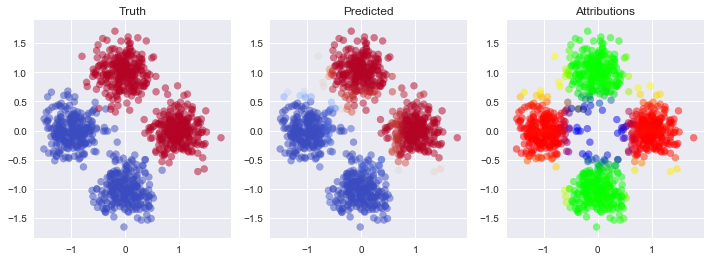

In [8]:
x, y = datagen_A(1024)
p = m.predict(x)
q = m.model_int.predict(x)
a = get_attributions(q, m.C_residual)

plt.figure(figsize = (12, 4))
plt.subplot(1,3,1)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5)
plt.title('Truth')
plt.subplot(1,3,2)
plt.scatter(x[:,0], x[:,1], c = p[:,0], alpha=0.5)
plt.title('Predicted')
plt.subplot(1,3,3)
plt.scatter(x[:,0], x[:,1], c = a, alpha=0.5)
plt.title('Attributions')

### Dataset C

Combined dataset generators A and B, refered to as _toy problem (b)_ in the paper. 

In [9]:
tf.keras.backend.clear_session()

In [10]:
m = Interpretable_FF(hidden_dim = 16)
m.compile()
# m.model.summary()

In [11]:
data_gen = make_generator(datagen_C, {'bs': 256, 'noise_level': 0.25})

m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 0.4753 - acc: 0.8562
Epoch 2/30
500/500 - 1s - loss: 0.1970 - acc: 0.9940
Epoch 3/30
500/500 - 1s - loss: 0.1685 - acc: 0.9942
Epoch 4/30
500/500 - 1s - loss: 0.1492 - acc: 0.9945
Epoch 5/30
500/500 - 1s - loss: 0.1304 - acc: 0.9943
Epoch 6/30
500/500 - 1s - loss: 0.1134 - acc: 0.9943
Epoch 7/30
500/500 - 1s - loss: 0.1035 - acc: 0.9942
Epoch 8/30
500/500 - 1s - loss: 0.0930 - acc: 0.9945
Epoch 9/30
500/500 - 1s - loss: 0.0862 - acc: 0.9945
Epoch 10/30
500/500 - 1s - loss: 0.0804 - acc: 0.9946
Epoch 11/30
500/500 - 1s - loss: 0.0736 - acc: 0.9947
Epoch 12/30
500/500 - 1s - loss: 0.0721 - acc: 0.9948
Epoch 13/30
500/500 - 1s - loss: 0.0689 - acc: 0.9948
Epoch 14/30
500/500 - 1s - loss: 0.0689 - acc: 0.9946
Epoch 15/30
500/500 - 1s - loss: 0.0656 - acc: 0.9947
Epoch 16/30
500/500 - 1s - loss: 0.0630 - acc: 0.9948
Epoch 17/30
500/500 - 1s - loss: 0.0615 - acc: 0.9953
Epoch 18/30
500/500 - 1s - loss: 0.0636 - acc: 0.9947
Epoch 19/30
500/500 - 1s - loss: 0.06

Text(0.5, 1.0, 'Attributions')

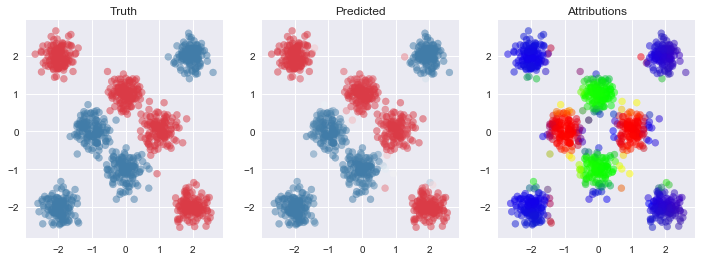

In [12]:
x, y = datagen_C(1024, noise_level = 0.25)
p = m.predict(x)
q = m.model_int.predict(x)
a = get_attributions(q, m.C_residual, mode='L1')

plt.figure(figsize = (12, 4))
plt.subplot(1,3,1)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5, cmap=g_cmap)
plt.title('Truth')
plt.subplot(1,3,2)
plt.scatter(x[:,0], x[:,1], c = p[:,0], alpha=0.5, cmap=g_cmap)
plt.title('Predicted')
plt.subplot(1,3,3)
plt.scatter(x[:,0], x[:,1], c = a, alpha=0.5)
plt.title('Attributions')

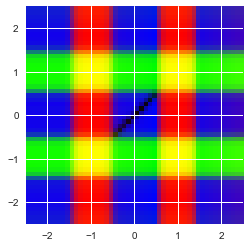

In [13]:
''' Better visualise the attribution space, i.e. p(M|X).
Note: we also compute them for out of distribution points. '''
mesh_size = 50
mx, my = np.meshgrid(np.linspace(-2.5, 2.5, mesh_size), np.linspace(-2.5, 2.5, mesh_size))
X = np.concatenate([mx.reshape((-1, 1)), my.reshape((-1, 1))], axis=-1)
A = get_attributions(m.model_int.predict(X), m.C_residual)
plt.imshow(A.numpy().reshape((mesh_size, mesh_size, -1)), extent=[-2.5,2.5,-2.5,2.5])

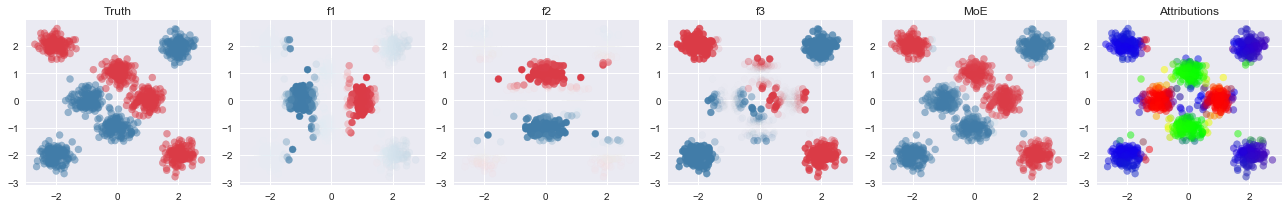

In [14]:
''' Plot from the paper with alpha transparency for attribution '''

def pred_to_col(q, a):
    ''' col with alpha for confidence '''
    p_ = []
    for i in range(q.shape[1]):
        q_ = g_cmap(plt.Normalize(-1, 1)(q[:,i]))
        q_[:,3] = a[:,i]
        # p_.append([tuple(j) for j in q_])
        p_.append(q_)
    return p_

x, y = datagen_C(1024, noise_level = 0.25)
p = m.predict(x)
q = m.model_int.predict(x)
a = get_attributions(q, m.C_residual, mode='L1')

colored_pred = pred_to_col(q, a)

plt.figure(figsize = (3 * 6, 3))
plt.subplot(1,6,1)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5, cmap=g_cmap)
plt.title('Truth')

plt.subplot(1,6,2)
plt.scatter(x[:,0], x[:,1], c = colored_pred[0])
plt.title('f1')

plt.subplot(1,6,3)
plt.scatter(x[:,0], x[:,1], color = colored_pred[1])
plt.title('f2')

plt.subplot(1,6,4)
plt.scatter(x[:,0], x[:,1], c = colored_pred[2])
plt.title('f3')

plt.subplot(1,6,5)
plt.scatter(x[:,0], x[:,1], c = p[:,0], alpha=0.5, cmap=g_cmap)
plt.title('MoE')

plt.subplot(1,6,6)
plt.scatter(x[:,0], x[:,1], c = a, alpha=0.5)
plt.title('Attributions')

plt.tight_layout()

### Dataset D

Same problem but with independent dims. The attribution also works well.

In [15]:
tf.keras.backend.clear_session()

In [16]:
m = Interpretable_FF(input_dim = 4, hidden_dim = 16)
m.compile()
# m.model.summary()

In [17]:
data_gen = make_generator(datagen_D, {'bs': 512})

m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 0.4048 - acc: 0.8799
Epoch 2/30
500/500 - 1s - loss: 0.0763 - acc: 0.9986
Epoch 3/30
500/500 - 1s - loss: 0.0517 - acc: 0.9988
Epoch 4/30
500/500 - 1s - loss: 0.0473 - acc: 0.9987
Epoch 5/30
500/500 - 1s - loss: 0.0451 - acc: 0.9987
Epoch 6/30
500/500 - 1s - loss: 0.0444 - acc: 0.9988
Epoch 7/30
500/500 - 1s - loss: 0.0439 - acc: 0.9988
Epoch 8/30
500/500 - 1s - loss: 0.0436 - acc: 0.9988
Epoch 9/30
500/500 - 1s - loss: 0.0446 - acc: 0.9986
Epoch 10/30
500/500 - 1s - loss: 0.0447 - acc: 0.9988
Epoch 11/30
500/500 - 1s - loss: 0.0437 - acc: 0.9987
Epoch 12/30
500/500 - 1s - loss: 0.0441 - acc: 0.9989
Epoch 13/30
500/500 - 1s - loss: 0.0437 - acc: 0.9988
Epoch 14/30
500/500 - 1s - loss: 0.0434 - acc: 0.9988
Epoch 15/30
500/500 - 1s - loss: 0.0441 - acc: 0.9988
Epoch 16/30
500/500 - 1s - loss: 0.0438 - acc: 0.9987
Epoch 17/30
500/500 - 1s - loss: 0.0428 - acc: 0.9987
Epoch 18/30
500/500 - 1s - loss: 0.0437 - acc: 0.9987
Epoch 19/30
500/500 - 1s - loss: 0.04

Text(0.5, 1.0, 'Attributions')

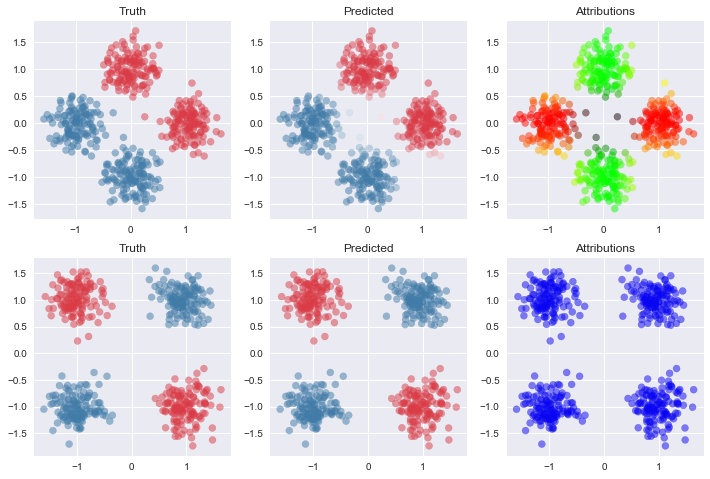

In [18]:
x, y = datagen_D(1024)
p = m.predict(x)
a = get_attributions(m.model_int.predict(x), m.C_residual)

plt.figure(figsize = (12, 8))
plt.subplot(2,3,1)
plt.scatter(x[:512,0], x[:512,1], c = y[:512,0], alpha=0.5, cmap=g_cmap)
plt.title('Truth')
plt.subplot(2,3,2)
plt.scatter(x[:512,0], x[:512,1], c = p[:512,0], alpha=0.5, cmap=g_cmap)
plt.title('Predicted')
plt.subplot(2,3,3)
plt.scatter(x[:512,0], x[:512,1], c = a[:512], alpha=0.5)
plt.title('Attributions')

plt.subplot(2,3,4)
plt.scatter(x[512:,2], x[512:,3], c = y[512:,0], alpha=0.5, cmap=g_cmap)
plt.title('Truth')
plt.subplot(2,3,5)
plt.scatter(x[512:,2], x[512:,3], c = p[512:,0], alpha=0.5, cmap=g_cmap)
plt.title('Predicted')
plt.subplot(2,3,6)
plt.scatter(x[512:,2], x[512:,3], c = a[512:], alpha=0.5)
plt.title('Attributions')

## Library

As a mention, a general class for interpretable multilayered neural network is implemented in `multilayered_nn.py`.

Those models are parametrised with usual multi-layered parameters (number of hidden layers, activation, ...) and additional parameters `"input_node_partition"` and `"attribution_subsets"` that denote respectively the partioning of $X$ into $X_1, \dots X_N$ and then the combinaisons into interpretation subsets $S_1, \dots S_H$ using those partitioned subsets.

In [19]:
import sys
sys.path.append('../models')

from multilayered_nn import *

In [20]:
tf.keras.backend.clear_session()
params = {
    'input_dim': (2,),
    'hidden_layers_dims': [16, 8],
    'activation': 'relu',
    
    'input_node_partition': [(0, 1), (1, 2)],
    'attribution_subsets':  [(True, False), (False, True), (True, True)],
}

m = Attr_Binary_FF_list(params)
m.compile()

In [21]:
data_gen = make_generator(datagen_C, {'bs': 256})

m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 49.1377 - acc: 0.8568
Epoch 2/30
500/500 - 1s - loss: 36.9629 - acc: 0.9969
Epoch 3/30
500/500 - 1s - loss: 36.6177 - acc: 0.9958
Epoch 4/30
500/500 - 1s - loss: 36.1616 - acc: 0.9950
Epoch 5/30
500/500 - 1s - loss: 35.9224 - acc: 0.9948
Epoch 6/30
500/500 - 1s - loss: 35.7383 - acc: 0.9945
Epoch 7/30
500/500 - 1s - loss: 35.6809 - acc: 0.9946
Epoch 8/30
500/500 - 1s - loss: 35.6360 - acc: 0.9945
Epoch 9/30
500/500 - 1s - loss: 35.6359 - acc: 0.9945
Epoch 10/30
500/500 - 1s - loss: 35.6005 - acc: 0.9944
Epoch 11/30
500/500 - 1s - loss: 35.6626 - acc: 0.9948
Epoch 12/30
500/500 - 1s - loss: 35.5606 - acc: 0.9948
Epoch 13/30
500/500 - 1s - loss: 35.5819 - acc: 0.9947
Epoch 14/30
500/500 - 1s - loss: 35.5782 - acc: 0.9950
Epoch 15/30
500/500 - 1s - loss: 35.6555 - acc: 0.9945
Epoch 16/30
500/500 - 1s - loss: 35.6178 - acc: 0.9947
Epoch 17/30
500/500 - 1s - loss: 35.6361 - acc: 0.9945
Epoch 18/30
500/500 - 1s - loss: 35.5901 - acc: 0.9951
Epoch 19/30
500/500

Text(0.5, 1.0, 'Attributions')

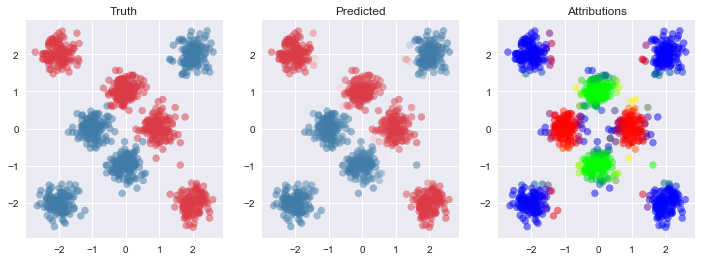

In [22]:
x, y = datagen_C(1024, noise_level = 0.25)
p = m.predict(x)
q = m.model_int.predict(x)
a = get_attributions(q, m.C_residual, mode='L1')

plt.figure(figsize = (12, 4))
plt.subplot(1,3,1)
plt.scatter(x[:,0], x[:,1], c = y[:,0], alpha=0.5, cmap=g_cmap)
plt.title('Truth')
plt.subplot(1,3,2)
plt.scatter(x[:,0], x[:,1], c = p[:,0], alpha=0.5, cmap=g_cmap)
plt.title('Predicted')
plt.subplot(1,3,3)
plt.scatter(x[:,0], x[:,1], c = a, alpha=0.5)
plt.title('Attributions')